# AA 203 Recitation 5: Training neural networks

## Empirical Risk Minimization and Stochastic Gradient Descent

Objective:
    
$$
    f^* = \text{argmin}_{f \in \mathcal{F}} \mathbb{E}[\ell(f(x), y)]
$$

Can't evaluate because this requires generative density. So, empirical approximation

$$
\hat{f} = \text{argmin}_{f \in \mathcal{F}} \frac{1}{d} \sum_{i=1}^{d} \ell(f(x_i), y_i)
$$

Parameterize function as $f_{\theta}$. Update parameters via
$$
\theta' \gets \theta - \alpha \nabla_{\theta} \hat{R}(\theta) = \theta - \frac{\alpha}{d} \sum_{i=1}^{d} \nabla_{\theta} \ell(f_{\theta}(x_i), y_i)
$$

## Backpropagation and Automatic Differentiation

Must now compute derivative of loss with respect to model parameters. Assuming differentiable $\ell$, have

$$
\nabla_{\theta} \ell(f_{\theta}(x), y) = \nabla_{\hat{y}} \ell(\hat{y}, y) \nabla_{\theta} f_{\theta}(x)
$$

So, we need to compute gradient of model output w.r.t. parameters. Consider _scalar_ neural network

$$
\hat{y} = f(x) = w_3 h(w_2 h(w_1 x)).
$$

Gives partial derivatives

$$
\frac{\partial \hat{y}}{\partial w_1} = w_3\, h'(w_2 h(w_1 x))\, w_2 h'(w_1 x) \,x
$$

$$
\frac{\partial \hat{y}}{\partial w_2} = w_3\, h'(w_2 h(w_1 x))\, h(w_1 x)
$$

$$
\frac{\partial \hat{y}}{\partial w_3} = h(w_2 h(w_1 x))
$$

With $o_{k+1} = w_{k+1} h(o_k)$ and $h(o_0) = x$, the gradient w.r.t. a parameter in a scalar network is

$$
\frac{\partial \hat{y}}{\partial w_k} = \prod_{i=k}^{K-1} w_{i+1} h'(o_i) \prod_{i=0}^{k-1} h(o_i).
$$

## Basics

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
a = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
c = torch.exp(-0.5*a**2 + b)
c.backward()
print(a.grad,b.grad)

tensor(-0.7358) tensor(0.3679)


In [5]:
w_true = 2.03
b_true = 1.

def generate_data(w,b):

    x = np.random.rand(1,1)
    y = w*x + b + 0.25*np.random.randn(1,1)
    return (x,y)

In [6]:
w = torch.tensor([[1.]], requires_grad=True)
b = torch.tensor([[0.]], requires_grad=True)

x_stack = []
y_stack = []
for i in range(1000):
    x_,y_ = generate_data(w_true, b_true)
    x = torch.from_numpy(x_)
    y = torch.from_numpy(y_)
    
    x_stack.append(x_)
    y_stack.append(y_)
    
    y_pred = x * w + b
    loss = (y_pred - y)**2
    loss.backward()
    
    with torch.no_grad():
        w -= 0.1*w.grad
        b -= 0.1*b.grad

        w.grad.zero_()
        b.grad.zero_()

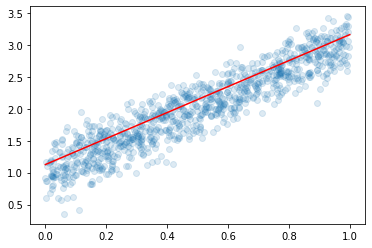

In [7]:
plt.scatter(x_stack,y_stack, alpha=0.15)

w_hat = w.item()
b_hat = b.item()

x_viz = np.linspace(0,1,100)
y_viz = [w_hat*x + b_hat for x in x_viz]
plt.plot(x_viz,y_viz, color='r')
plt.show()

In [8]:
print(w_hat)
print(b_hat)

2.032088041305542
1.1269060373306274


## Neural Networks

In [9]:
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [10]:
class TrickyFunctionDataset(Dataset):
    def __init__(self, num_samples=2000):
        self.n = num_samples
        self.generate_data()
        
        
    def generate_data(self):
        # sample x
        self.X = np.zeros(self.n)
        self.Y = np.zeros(self.n)
        for i in range(self.n):
            x = np.random.rand()*10-5
            y = 2./(1 + np.exp(-x**2)) + 0.25*np.cos(x) + 0.1*np.random.randn()
            
            self.X[i] = x
            self.Y[i] = y
        
    def __len__(self):
        return self.n
    
    def __getitem__(self,idx):
        return(self.X[idx:idx+1], self.Y[idx:idx+1])
        
function_dataset = TrickyFunctionDataset()
function_dataloader = DataLoader(function_dataset, batch_size=20, shuffle=True, num_workers=4)

In [11]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, hidden_dim1=32, hidden_dim2=32):
        super().__init__()
        self.fc1 = nn.Linear(1,hidden_dim1)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        
    def forward(self,x):
        h1 = self.activation(self.fc1(x))
        h2 = self.activation(self.fc2(h1))
        return self.fc3(h2)

In [12]:
def mse_loss(y,ypred):
    return torch.mean((y-ypred)**2)

In [13]:
model = FeedforwardNetwork().double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    for i, (x,y) in enumerate(function_dataloader):        
        ypred = model(x)
        loss = mse_loss(y,ypred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}; Loss = {}'.format(epoch, loss.item()))

Epoch 0; Loss = 0.15787611595532527
Epoch 1; Loss = 0.021924597839628475
Epoch 2; Loss = 0.007344828171434001
Epoch 3; Loss = 0.008145538611097581
Epoch 4; Loss = 0.01691468305885082
Epoch 5; Loss = 0.012052967547163349
Epoch 6; Loss = 0.008699271483419892
Epoch 7; Loss = 0.010186902296938707
Epoch 8; Loss = 0.005922704676992314
Epoch 9; Loss = 0.015422028624099285
Epoch 10; Loss = 0.014021320576695365
Epoch 11; Loss = 0.011039429869205553
Epoch 12; Loss = 0.018023062583538803
Epoch 13; Loss = 0.013961134769416636
Epoch 14; Loss = 0.005694751239437537
Epoch 15; Loss = 0.006010207451795108
Epoch 16; Loss = 0.017528453421535712
Epoch 17; Loss = 0.012645508596255564
Epoch 18; Loss = 0.015355882548481983
Epoch 19; Loss = 0.012317290009525268


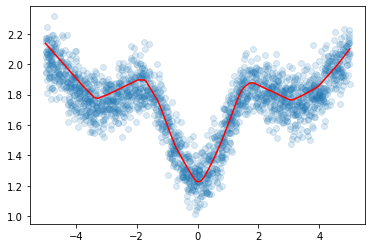

In [14]:
x_data = [] 
y_data = [] 

for i in range(function_dataset.n):
    x = function_dataset.__getitem__(i)[0].item()
    y = function_dataset.__getitem__(i)[1].item()
    x_data.append(x)
    y_data.append(y)

plt.scatter(x_data,y_data,alpha=0.15)

x_viz = np.linspace(-5,5,300)
y_viz = [model(torch.tensor([x])).item() for x in x_viz]
plt.plot(x_viz,y_viz, color='r')
plt.show()